<h1><b>Statistique en Bioinformatique : </b> TME solo </h1><br>
<div class="alert alert-warning" role="alert" style="margin: 10px">
<p><b>Soumission</b></p>
<ul>
<li>Renommer le fichier TMEsolo_2023.ipynb pour NomEtudiant_TMEsolo.ipynb </li>
<li>Envoyer via moodle</li>
</ul>
</div>
<div class="alert alert-warning" role="alert" style="margin: 10px">

</div>

<h2> Recherche de Motifs</h2>
Nous allons développer un algorithme très simple pour la recherche de motifs dans des séquences d'ADN et comparer les résultats avec l'algorithme Expectation et Maximization. 

In [1]:
# Configuration

import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(0)
np.random.seed(0)

nuc = ['A', 'C', 'G', 'T']


<b>1. Génération des séquences aléatoires </b>:
Nous allons d'abord générer des données artificielles, un jeu de données de séquences ayant le motif (positives). Pour générer les séquences positives, 
utilisez la matrice de fréquence ci-dessous, la séquence consensus de ce motif "AGTATAG".

In [2]:


k = 7 #taille du motif
iter = 10 #nombre de sequences

MotifConsensus = "AGTATAG"

freq = np.array([
  [1000,  12,   3,  1000,   5,   1000,   1],
  [10,    8,   3,   3,   0,    10,   1],
  [4,   1000,   2,   7,   5,    13,   1000],
  [6,    10,  1000,   5,   1000,   6,   1]])


<b> Générer de séquences positives </b>:
Écrivez une fonction qui génère N séquences de taille T contenant le motif "AGTATAG". 
La séquence du motif doit être généré en utilisant la matrice de Probabilité produite à partir de la matrice de fréquence.
La position d'insertion du motif est aléatoire et ses residues sont en **majuscules**, 
les autres residues de la séquence hors le motif sont représentés en minuscule. 



In [3]:

def createPosSequences(freq, nuc, k=21, N=100, T=100):
  """
  Genere N sequences positives (ayant le motif)
  entrée freq : matrice de frequences qui represent le motif d'interet
  entrée nuc  : alphabet
  entrée k    : taille du motif
  entrée N    : nombre de sequences
  entrée T    : taille de chaque sequence
  sortie posMotif  : list contenant les sequences positives, motif implanté
  sortie motifs    : list contenant les motifs selement
  """

  motifs = [''.join([random.choices(nuc, freq[:, pos])[0] for pos in range(k)]) for _ in range(N)]
  gen_random = lambda size: ''.join([random.choice(nuc) for _ in range(size)]).lower()

  def gen_seq(motif):
    insertion_pos = random.randint(0, T - k)
    return gen_random(insertion_pos) + motif + gen_random(T - insertion_pos - k)

  posMotif = [gen_seq(motif) for motif in motifs]

  return posMotif, motifs

posMotif, motifs = createPosSequences(freq, nuc, k, iter, 30)

pos = [x.upper() for x in posMotif] #transform toutes les séquences en majuscules


<b> 2. Générer la matrice de poids position</b> à partir de séquences générer artificiellement `motifs` 
puis comparer la matrice générée avec la matrice originale `freq`, que remarquez vous?

In [4]:
#Computing wi(a)
def matricePoidsPosition(motifs, nuc, k):
  """
  Genere la matrice de poids position à partir de motifs
  entrée motifs : list  contenant les motifs d'interets
  entrée nuc  : alphabet
  entrée k    : taille du motif
  sortie pwm  : matrice de poids position qui represent les motifs
  """
  q = len(nuc)
  m = len(motifs)
  k = len(motifs[0])

  counts = np.zeros((q, k), dtype=int)
  pseudocount = 1.0

  for ch_index in range(k):
      for sequence in motifs:
          counts[nuc.index(sequence[ch_index]), ch_index] += 1

  PWM = (counts + pseudocount) / (m + q * pseudocount)
  return PWM

PWM = matricePoidsPosition(motifs, nuc, k);
print (PWM.T)
print(np.abs((freq / freq.sum(axis=0)).T - PWM.T))


[[0.78571429 0.07142857 0.07142857 0.07142857]
 [0.07142857 0.07142857 0.78571429 0.07142857]
 [0.07142857 0.07142857 0.07142857 0.78571429]
 [0.78571429 0.07142857 0.07142857 0.07142857]
 [0.07142857 0.07142857 0.07142857 0.78571429]
 [0.78571429 0.07142857 0.07142857 0.07142857]
 [0.07142857 0.07142857 0.78571429 0.07142857]]
[[0.19467787 0.06162465 0.067507   0.06554622]
 [0.05977809 0.06366158 0.1851595  0.06171983]
 [0.06845238 0.06845238 0.06944444 0.20634921]
 [0.19950739 0.06847291 0.06453202 0.06650246]
 [0.06647808 0.07142857 0.06647808 0.20438472]
 [0.18610301 0.0617104  0.05879495 0.06559767]
 [0.07043156 0.07043156 0.21129469 0.07043156]]


<font color="#0000FF">Réponse : Les deux matrices ne se ressemblent que vaguement en raison du faible nombre de séquences générées (10).</font>

<b>3. Chercher les motifs en utilisant l'algorithme `motifSearch` </b>:
<br>
Faire une fonction pour chercher le motif le plus plus frequents dans l'ensemble de sequences positives `pos`. 

In [5]:
def motifSearch(k: int, sequences: list[str]):
    """
    Cherche les motifs de taille k dans un ensemble de séquences
    entrée k : taille du motif
    entrée séquences : liste de sequences
    sortie motifs: dictionnaire de motifs, clé=motif, valeur = fréquence d'observation
    >>>searchMotifs(3, ['TAAGTAA', 'TATAA', 'CTATC'])
    {'TAA': 3, 'AAG': 1, 'AGT': 1, 'GTA': 1, 'TAT': 2, 'ATA': 1, 'CTA': 1, 'ATC': 1}
    """
    words = [seq[offset:(offset + k)] for seq in sequences for offset in range(len(seq) - k + 1)]
    motifs = dict[str, int]()

    for word in words:
        motifs[word] = motifs.get(word, 0) + 1

    return motifs

def getTopMotifs(motifs: dict[str, int], top: int = 1):
    """
    renvoyer les top motifs le plus frequent
    entrée motifsFound: dictionnaire de motifs, clé=motif, valeur = fréquence d'observation
    entrée top : les top plus frequent
    sortie motifsfreq: dictionnaire contenant les top motifs les plus fréquents, clé=motif, valeur = fréquence d'observation
    >>>getTopMotifs({'TAA': 3, 'AAG': 1, 'AGT': 1, 'GTA': 1, 'TAT': 2, 'ATA': 1, 'CTA': 1, 'ATC': 1}, 2)
    {'TAA': 3, 'TAT': 2}
    """
    min_freq = sorted(motifs.values(), reverse=True)[top - 1]
    return { motif: freq for motif, freq in motifs.items() if freq >= min_freq }


assert motifSearch(3, ['TAAGTAA', 'TATAA', 'CTATC']) == {'TAA': 3, 'AAG': 1, 'AGT': 1, 'GTA': 1, 'TAT': 2, 'ATA': 1, 'CTA': 1, 'ATC': 1}
assert getTopMotifs({'TAA': 3, 'AAG': 1, 'AGT': 1, 'GTA': 1, 'TAT': 2, 'ATA': 1, 'CTA': 1, 'ATC': 1}, 2) == {'TAA': 3, 'TAT': 2}

motifsFound = motifSearch(k, pos)
topMotifs = getTopMotifs(motifsFound, 1)
print (topMotifs)


{'AGTATAG': 10}


4. Avez vous trouvez le motif N fois dans l'ensemble de séquences positives `pos`? Justifiez votre réponse.

<font color="#0000FF"> Réponse: Oui, on a généré N = 10 séquences et il y a dix fois le motif AGTATAG dans les séquences. On aurait pu trouver plus de N séquences en raison du background aléatoire ou moins de N si les motifs générés n'étaient pas exactement identiques à la séquence consensus.</font>

5. Utiliser l'algorithme Expectation-Maximisation pour chercher un motif de taille k dans l'ensemble de séquences `pos`.

Sequence  0: AGTATAG  7
Sequence  1: AGTATAG 19
Sequence  2: AGTATAG 12
Sequence  3: AGTATAG 20
Sequence  4: AGTATAG  5
Sequence  5: AGTATAG 21
Sequence  6: AGTATAG 18
Sequence  7: AGTATAG 15
Sequence  8: AGTATAG  1
Sequence  9: AGTATAG  6


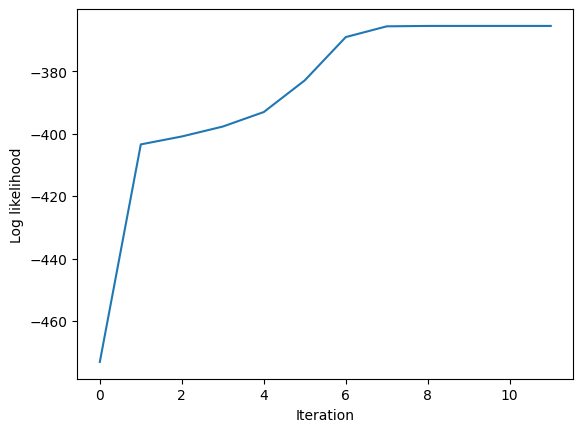

In [6]:
def EM(raw_seqs: list[str], k: int, nucl: list[str], *, epsilon: float):
    seqs = np.array([[nucl.index(n) for n in seq] for seq in raw_seqs])

    # Initialize P
    P = np.random.rand(len(nucl), k + 1)
    P /= P.sum(axis=0)

    likelihoods = list[float]()

    for _ in range(100):
        # Step E
        Z_unnormalized = np.zeros((len(seqs), len(seqs[0]) - k + 1))

        for offset in range(Z_unnormalized.shape[1]):
            Z_unnormalized[:, offset] = np.prod(P[:, 0][seqs[:, :offset]], axis=1) * np.prod(P[seqs[:, offset:(offset + k)], np.arange(k) + 1], axis=1) * np.prod(P[:, 0][seqs[:, (offset + k):]], axis=1)

        # Normalization
        Z = Z_unnormalized / Z_unnormalized.sum(axis=1, keepdims=True)

        # Step M
        pseudocount = 1.0
        ns = np.array([[(Z * (seqs[:, pos:(-(k - pos - 1) or None)] == l)).sum() for pos in range(k)] for l in range(len(nucl))])
        n = np.c_[np.bincount(seqs.flat, minlength=len(nucl)) - ns.sum(axis=1), ns]
        P = (n + pseudocount) / (n.sum(axis=0) + len(nucl) * pseudocount)

        # Compute likelihood
        likelihoods.append(np.log((len(seqs[0]) - k + 1) ** -len(seqs)) + np.log(Z_unnormalized.sum(axis=1)).sum())

        if len(likelihoods) >= 2 and abs(likelihoods[-2] - likelihoods[-1]) <= epsilon:
            break

    return likelihoods, Z.argmax(axis=1)

def EM_repeated(iter: int, seqs: list[str], k: int, nucl: list[str], *, epsilon: float):
    max_likelihood = -np.inf

    for _ in range(iter):
        likelihoods, offsets = EM(seqs, k, nucl, epsilon=epsilon)

        if likelihoods[-1] > max_likelihood:
            max_likelihood = likelihoods[-1]
            result = likelihoods, offsets

    return result


likelihoods, offsets = EM_repeated(15, pos, k, nuc, epsilon=1e-4)
em_motifs = [seq[offset:(offset + k)] for seq, offset in zip(pos, offsets)]

for seq_index, (seq, offset) in enumerate(zip(pos, offsets)):
    print(f'Sequence {seq_index:>2}: {seq[offset:(offset + k)]} {(offset + 1):>2}')

fig, ax = plt.subplots()

ax.plot(likelihoods)
ax.set_xlabel('Iteration')
ax.set_ylabel('Log likelihood')

plt.show()


6. Comparez les motifs trouvés par EM et l'algorithme `motifSearch` avec les motifs `posMotif`, 
où les vrais motifs sont montrés en lettre majuscule. Quelle est la performance de ces deux programmes? 

In [7]:
from collections import Counter


print('Motifs motifSearch', topMotifs)
print('Motifs EM', getTopMotifs(dict(Counter(em_motifs)), 1))


Motifs motifSearch {'AGTATAG': 10}
Motifs EM {'AGTATAG': 10}


<font color="#0000FF"> Réponse: Les deux programmes renvoient des résultats identiques ici. L'algorithme EM a néanmoins la garantie de retourner exactement N séquences.</font>